In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install watermark
!pip install --upgrade pandas
!pip install --upgrade opencv-python
!pip install --upgrade matplotlib

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision,PIL,matplotlib,albumentations,tqdm --conda

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Brain Tumor Semantic Segmentation')

In [ ]:
# Setup environment and import libraries

import numpy as np
import os
import pandas as pd
import time
import torch
import matplotlib.pyplot as plt
import albumentations as albu
import cv2
import random
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch import nn, optim
from PIL import Image
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from utils.set_seed import set_seed
import warnings

warnings.filterwarnings("ignore")

set_seed(42) # Set seed for reproducibility

START_TIME = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(DEVICE)}")
else:
    print("CUDA is not available. Switching to CPU.")

**Realce de Contraste:**
O realce de contraste pode destacar as bordas dos tumores e estruturas cerebrais, tornando-as mais visíveis para o modelo. Técnicas como realce de histograma ou realce baseado em gradientes podem ser aplicadas.

**Redução de ruído:**
A aplicação de técnicas de redução de ruído, como filtragem gaussiana ou filtragem bilateral, pode ajudar a melhorar a qualidade das imagens e reduzir informações indesejadas durante a segmentação.

**Suavização de bordas:**
Em algumas aplicações, pode ser benéfico suavizar as bordas das imagens para obter segmentações mais suaves e menos ruidosas.

In [ ]:
file_path = os.path.join(r'/content/drive/MyDrive/Brain Tumor Semantic Segmentation/data/raw/metadata.csv')

In [ ]:
# Import dataset metadata

df = pd.read_csv(file_path)
df.drop(columns=['Tumor Border'], inplace = True)
df = pd.DataFrame(df)
df.head().style

In [ ]:
# Caminhos desejados (sem a barra invertida final)
novo_caminho_img = '/content/drive/MyDrive/Brain Tumor Semantic Segmentation/data/raw/png'
novo_caminho_mask = '/content/drive/MyDrive/Brain Tumor Semantic Segmentation/data/raw/masks'

# Atualize completamente os caminhos nas colunas 'Image Path' e 'Mask Path'
df['Image Path'] = novo_caminho_img + '/' + df['ID'].astype(str) + '.png'
df['Mask Path'] = novo_caminho_mask + '/' + df['ID'].astype(str) + '.png'

df.head().style

In [ ]:
unique_pids = df['PID'].unique()
train_pid, test_pid = train_test_split(unique_pids, test_size=0.2)

train_df = df[df['PID'].isin(train_pid)]
test_df = df[df['PID'].isin(test_pid)]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

In [ ]:
train_df['Image Path'][0]

In [ ]:
# Check label distribution on train and test sets

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(train_df['Label'], bins=3, color='#5d5555')
ax[0].set_title('Train')
ax[1].hist(test_df['Label'], bins=3, color='#5d5555')
ax[1].set_title('Test')

In [ ]:
class BrainTumorDataset(Dataset):
    """Brain Tumor Dataset. Read images, apply augmentation and preprocessing transformations."""

    CLASSES = ['unlabelled', 'meningioma', 'glioma', 'pituitary_tumor']

    def __init__(
            self,
            dataframe,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.images_fps = dataframe["Image Path"].tolist()
        self.masks_fps = dataframe["Mask Path"].tolist()

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # read mask
        raw_mask = cv2.imread(self.masks_fps[i], 0)

        # Build a binary mask for each class based on the values in the raw_mask
        masks = [(raw_mask == v).astype(np.float32) for v in [0, 85, 170, 255]]
        mask = np.stack(masks, axis=-1)  # Change axis to -1 for channel last format

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Channel First
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        return image, mask

    def visualize_sample(self, i):
        image, mask = self[i]

        # Extracting channels for 'meningioma', 'glioma', and 'pituitary_tumor'
        meningioma_mask = mask[1,:,:]
        glioma_mask = mask[2,:,:]
        pituitary_tumor_mask = mask[3,:,:]

        print("Shape of image:", image.shape)
        print("Shape of masks:", mask.shape)

        # Convert image to WxHxC for visualization
        image = np.transpose(image, (1, 2, 0))

        # Plotting
        fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))

        axs[0].imshow(image)
        axs[0].axis('off')
        axs[0].set_title('Exam Image')

        axs[1].imshow(meningioma_mask, cmap='gray')
        axs[1].set_title('Meningioma Mask')
        axs[1].axis('off')

        axs[2].imshow(glioma_mask, cmap='gray')
        axs[2].set_title('Glioma Mask')
        axs[2].axis('off')

        axs[3].imshow(pituitary_tumor_mask, cmap='gray')
        axs[3].set_title('Pituitary Tumor Mask')
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self.images_fps)

AUGMENTATION:


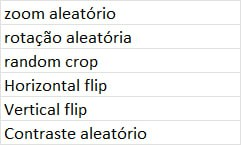

In [ ]:
def get_training_augmentation(image):
    alt = image[0]
    lar = image[1]
    train_transform = [albu.HorizontalFlip(p = .5),

                       albu.VerticalFlip(p = .5),

                       albu.RandomCrop(height = alt,
                                       width = lar,
                                       always_apply = False),

                       albu.ShiftScaleRotate(scale_limit = .0,
                                             rotate_limit = 50,
                                             shift_limit = .05,
                                             p = .5,
                                             border_mode = 0),

                       albu.OneOf([albu.RandomContrast(p = 1)],
                                   p = .5,),]

    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def get_preprocessing(image_size):
    """
    Construct preprocessing transform

    Args:
        image_size (tuple): Desired image size in the form of (height, width)

    Return:
        transform: albumentations.Compose
    """

    _transform = [
        albu.Resize(height=image_size[0], width=image_size[1], always_apply=True),
        albu.ToFloat(max_value=255.0),
    ]
    return albu.Compose(_transform)

In [ ]:
def preprocess(arq_image):
    image = cv2.imread(arq_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32)/255.0
    r, g, b = cv2.split(image)
    zeros = np.zeros_like(g)
    fig, axes = plt.subplots(2, 3, figsize = (10, 6))
    titulos = ['r', 'g', 'b']

    for i in range(3):
        axes[0][i].set_title(titulos[i])
        if i == 0:
            canal_mergido = cv2.merge([r, zeros, zeros])
        elif i == 1:
            canal_mergido = cv2.merge([zeros, g, zeros])
        else:
            canal_mergido = cv2.merge([zeros, zeros, b])

        axes[0][i].imshow(canal_mergido)
        axes[1][i].hist(image[..., i].ravel(), bins = 256, range = (0, 1), alpha = .9, color = titulos[i])
        axes[0][i].axis('off')
        fig.tight_layout()
    plt.show()

preprocess(train_df['Image Path'][34])

In [ ]:
IMAGE_SIZE = (224, 224)

train_dataset = BrainTumorDataset(dataframe = train_df,
                                  classes = ["meningioma", "glioma", "pituitary_tumor"],
                                  augmentation = get_training_augmentation(IMAGE_SIZE),
                                  preprocessing = get_preprocessing(IMAGE_SIZE),)

test_dataset = BrainTumorDataset(dataframe = test_df,
                                 classes=["meningioma", "glioma", "pituitary_tumor"],
                                 augmentation = None,
                                 preprocessing = get_preprocessing(IMAGE_SIZE),)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True, pin_memory = True)

In [ ]:
train_dataset.visualize_sample(random.randint(0, len(train_dataset) - 1))

In [ ]:
# Building basic blocks for the U-Net model with skip connections and the Kaiming He initialization

def mask_to_class(mask):
    return torch.argmax(mask, dim=1)

class EncodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, max_pooling=True):
        super(EncodingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.max_pooling = max_pooling
        if max_pooling:
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip_connection = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        skip_connection = x  # Set aside residual

        if self.max_pooling:
            x = self.maxpool(x)

        return x, skip_connection

class DecodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodingBlock, self).__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
        x = self.convT(x)
        x = torch.cat([x, skip_connection], dim=1)  # Concatenate along the channel dimension

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
# Build the U-Net model

class UNet(nn.Module):
    def __init__(self, in_channels, filters, n_classes):
        super(UNet, self).__init__()

        # Contracting Path
        self.encode_block1 = EncodingBlock(in_channels, filters, max_pooling=True)
        self.encode_block2 = EncodingBlock(filters, filters * 2, max_pooling=True)
        self.encode_block3 = EncodingBlock(filters * 2, filters * 4, max_pooling=True)
        self.encode_block4 = EncodingBlock(filters * 4, filters * 8, max_pooling=True)
        self.encode_block5 = EncodingBlock(filters * 8, filters * 16, max_pooling=False)

        # Expanding Path
        self.decode_block1 = DecodingBlock(filters * 16, filters * 8)
        self.decode_block2 = DecodingBlock(filters * 8, filters * 4)
        self.decode_block3 = DecodingBlock(filters * 4, filters * 2)
        self.decode_block4 = DecodingBlock(filters * 2, filters)

        self.final_conv = nn.Conv2d(filters, n_classes, kernel_size=1)

    def forward(self, x):

        # Contracting Path
        x, skip1_out = self.encode_block1(x)
        x, skip2_out = self.encode_block2(x)
        x, skip3_out = self.encode_block3(x)
        x, skip4_out = self.encode_block4(x)
        x, _ = self.encode_block5(x)

        # Expanding Path
        x = self.decode_block1(x, skip4_out)
        x = self.decode_block2(x, skip3_out)
        x = self.decode_block3(x, skip2_out)
        x = self.decode_block4(x, skip1_out)
        x = self.final_conv(x)

        return x

IMG_SIZE = (224, 224)
num_channels = 3
filters = 32
n_classes = 4

model = (
    UNet(in_channels=num_channels, filters=filters, n_classes=n_classes)
    .to(DEVICE)
    .apply(weights_init)
)

summary(model.cuda(), input_size=(num_channels, *IMG_SIZE))

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

# Define training parameters

LEARNING_RATE = 1e-4
num_epochs = 20
#loss_fn = nn.CrossEntropyLoss()
loss_fn = smp.losses.DiceLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)

In [ ]:
best_loss = float("inf")
epochs_without_improvement = 0
early_stopping_patience = 5

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    losses = []

    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)

        # forward
        with autocast():
            predictions = model(data)
            targets = mask_to_class(targets)
            loss = loss_fn(predictions, targets)


        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Store losses
        losses.append(loss.item())

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    # Calculate average loss
    average_loss = np.mean(losses)

    # Check if we need to save the model
    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Brain Tumor Semantic Segmentation/models/bestx_{START_TIME}.pt")
        print("Best Model Saved!")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Check for early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered!")
        break

    # Update the learning rate
    lr_scheduler.step(average_loss)

In [ ]:
# Load best model weights

model.load_state_dict(
    torch.load(
        #f"models/best_{START_TIME}.pt",
        f"/content/drive/MyDrive/Brain Tumor Semantic Segmentation/models/bestx_2024-03-19_13-09-08.pt", # Load previous training with 50 epochs and Dice Loss Multi-Class
        map_location=torch.device(DEVICE),
    )
)

In [ ]:
# Verify model performance on test set

def compute_metrics(pred, target):
    metrics = {}
    true_positives = np.zeros(4)
    false_positives = np.zeros(4)
    false_negatives = np.zeros(4)

    for channel in range(target.shape[0]):
        true_positive = np.logical_and(target[channel], pred == channel).sum()
        false_positive = np.logical_and(target[channel] == 0, pred == channel).sum()
        false_negative = np.logical_and(target[channel], pred != channel).sum()

        true_positives[channel] = true_positive
        false_positives[channel] = false_positive
        false_negatives[channel] = false_negative

    # Compute IoU
    union = true_positives + false_positives + false_negatives
    ious = np.where(union != 0, true_positives / union, 1)
    metrics['iou'] = ious

    # Compute Precision
    precision = np.where((true_positives + false_positives) != 0, true_positives / (true_positives + false_positives), 1)
    metrics['precision'] = precision

    # Compute Recall
    recall = np.where((true_positives + false_negatives) != 0, true_positives / (true_positives + false_negatives), 1)
    metrics['recall'] = recall

    # Compute Dice Score
    dice_score = np.where((2 * true_positives + false_positives + false_negatives) != 0,
                          2 * true_positives / (2 * true_positives + false_positives + false_negatives), 1)
    metrics['dice_score'] = dice_score

    # Compute F1 Score
    f1_score = np.where((precision + recall) != 0, 2 * (precision * recall) / (precision + recall), 1)
    metrics['f1_score'] = f1_score

    return metrics

def evaluate_model(dataloader, model, device):
    model.eval()
    metrics_data = {
        'iou': [],
        'precision': [],
        'recall': [],
        'dice_score': [],
        'f1_score': []
    }

    with torch.no_grad():
        for images, masks_true in dataloader:
            images, masks_true = images.to(device), masks_true.to(device)
            masks_pred = model(images)
            masks_pred = torch.nn.functional.softmax(masks_pred, dim=1)
            masks_pred = torch.argmax(masks_pred, dim=1)

            for i in range(images.size(0)):  # batch size
                metrics = compute_metrics(masks_pred[i].cpu().numpy(), masks_true[i].cpu().numpy())
                for metric, values in metrics.items():
                    metrics_data[metric].append(values)

    # Compute mean metrics
    mean_metrics = {}
    for metric, values in metrics_data.items():
        mean_metrics[metric] = np.mean(values, axis=0)

    return mean_metrics


mean_metrics = evaluate_model(dataloader=test_loader, model=model, device='cuda')

print("Mean Metrics on Test Dataset:")
for metric, values in mean_metrics.items():
    print(f"{metric.capitalize()}: {values}")

In [ ]:
def visualize_sample_prediction(dataloader, model, device, channel_names):
    """
    Visualizes a sample prediction.

    Parameters:
    - dataloader: DataLoader containing the test data.
    - model: The trained model.
    - device: The device to which the model and data are transferred before making a prediction.
    - channel_names: List containing names of the channels.
    """
    model.eval()

    # Get a random batch from the dataloader
    images, true_masks = next(iter(dataloader))
    images, true_masks = images.to(device), true_masks.to(device)

    # Take the first image and mask from the batch
    image, true_mask = images[0], true_masks[0]

    # Predict the mask using the model
    with torch.no_grad():
        pred = model(image.unsqueeze(0))
        pred = torch.nn.functional.softmax(pred, dim=1)  # Apply softmax
        pred_mask = pred.squeeze().cpu().numpy()

    # Move image and true_mask to cpu and convert to numpy
    image = image.cpu().numpy().transpose(1, 2, 0)
    true_mask = true_mask.cpu().numpy()

    # Plot
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))

    # Original Image
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Original Image")
    for ax in axs[0, 1:]:
        ax.axis('off')

    # Ground Truth Masks
    for ax, channel, name in zip(axs[1], true_mask, channel_names):
        ax.imshow(channel, cmap='gray')
        ax.set_title(f"True {name}")

    # Predicted Masks
    for ax, channel, name in zip(axs[2], pred_mask, channel_names):
        ax.imshow(channel, cmap='gray')
        ax.set_title(f"Pred {name}")

    plt.tight_layout()
    plt.show()


channel_names = ['Unlabelled', 'Meningioma', 'Glioma', 'Pituitary Tumor']
visualize_sample_prediction(test_loader, model, DEVICE, channel_names)
